# Feature Engineering and Data Analysis for Predictive Maintenance

This notebook examines and analyses data sources related to predictive maintenance as well as explores feature engineering methods from predictor variables over time. 


## Outline

- [Problem Description](#Problem-Description)
- [Data Sources](#Data-Sources)
   - [Telemetry](#Telemetry)
   - [Errors](#Errors)
   - [Maintenance](#Maintenance)
   - [Machines](#Machines)
   - [Failures](#Failures)
- [Feature Engineering](#Feature-Engineering)
  - [Lag Features from Telemetry](#Lag-Features-from-Telemetry)
  - [Lag Features from Errors](#Lag-Features-from-Errors)
  - [Days Since Last Replacement from Maintenance](#Days-Since-Last-Replacement-from-Maintenance)
  - [Machine Features](#Machine-Features) (Concatenating lag features created from datasets)


## 1. Problem Outline
A major problem faced by businesses in asset-heavy industries such as manufacturing is the significant costs that are associated with delays in the production process due to mechanical problems. Most of these businesses are interested in predicting these problems in advance so that they can proactively prevent the problems before they occur which will reduce the costly impact caused by downtime. Please refer to the [playbook for predictive maintenance](https://azure.microsoft.com/en-us/documentation/articles/cortana-analytics-playbook-predictive-maintenance/ ) for a detailed explanation of common use cases in predictive maintenance and modeling approaches.

In this notebook, we follow the ideas from the playbook referenced above and aim to provide the steps of implementing a predictive model for a scenario which is based on a synthesis of multiple real-world business problems. This example brings together common data elements observed among many predictive maintenance use cases and the data itself is created by data simulation methods.

## 2. Data Sources
### 2.1 Telemetry

The first data source is the telemetry time-series data which consists of voltage, rotation, pressure, and vibration measurements collected from 100 machines in real time averaged over every hour collected during the year 2015. Below, we display the first 10 records in the dataset. A summary of the whole dataset is also provided.

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

telemetry = pd.read_csv('PdM_telemetry.csv')
errors = pd.read_csv('PdM_errors.csv')
maint = pd.read_csv('PdM_maint.csv')
failures = pd.read_csv('PdM_failures.csv')
machines = pd.read_csv('PdM_machines.csv')

print(telemetry.shape)
print(errors.shape)
print(maint.shape)
print(failures.shape)
print(machines.shape)

(876100, 6)
(3919, 3)
(3286, 3)
(761, 3)
(100, 3)


In [2]:
# format datetime field which comes in as string
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'])
print(telemetry.head())

             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration  
0  45.087686  
1  43.413973  
2  34.178847  
3  41.122144  
4  25.990511  


In [3]:
telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = telemetry.loc[(telemetry['machineID'] == 1) &
                        (telemetry['datetime'] > pd.to_datetime('2015-01-01')) &
                        (telemetry['datetime'] < pd.to_datetime('2015-02-01')), ['datetime', 'volt','pressure','rotate','vibration']]

plot_df

,datetime,volt,pressure,rotate,vibration
0,2015-01-01 06:00:00,176.217853,113.077935,418.504078,45.087686
1,2015-01-01 07:00:00,162.879223,95.460525,402.747490,43.413973
2,2015-01-01 08:00:00,170.989902,75.237905,527.349825,34.178847
3,2015-01-01 09:00:00,162.462833,109.248561,346.149335,41.122144
4,2015-01-01 10:00:00,157.610021,111.886648,435.376873,25.990511
...,...,...,...,...,...
733,2015-01-31 19:00:00,179.435527,101.038917,425.748879,40.222383
734,2015-01-31 20:00:00,180.712544,81.468144,516.240814,41.565913
735,2015-01-31 21:00:00,186.138292,96.063227,493.527992,36.844321
736,2015-01-31 22:00:00,203.746333,94.339403,346.875533,40.998081


Text(0.5, 0, 'Date')

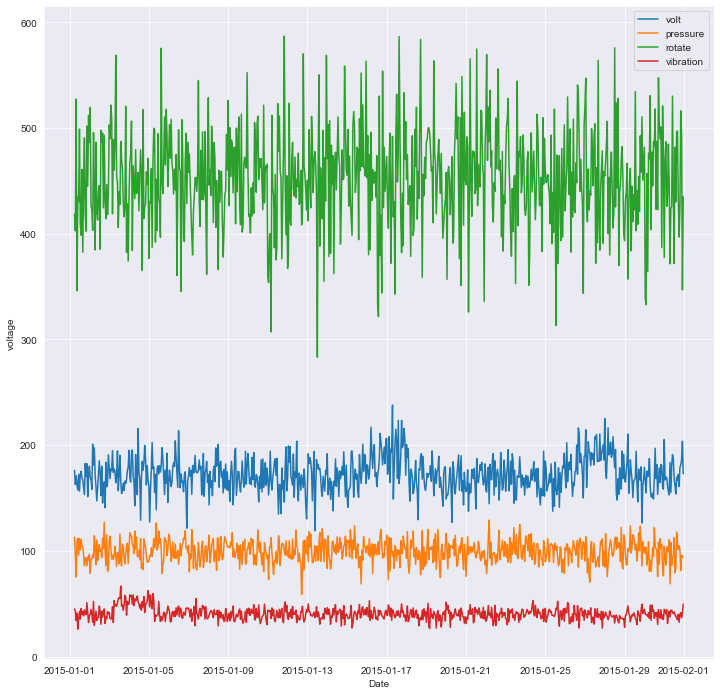

In [5]:
sns.set_style("darkgrid")
plt.figure(figsize=(12, 12))
sns.lineplot(y='volt',x='datetime',data=plot_df,label='volt')
sns.lineplot(y='pressure',x='datetime',data=plot_df,label='pressure')
sns.lineplot(y='rotate',x='datetime',data=plot_df,label='rotate')
sns.lineplot(y='vibration',x='datetime',data=plot_df,label='vibration')
plt.ylabel('voltage')
plt.xlabel('Date')

### 2.2 Errors

The error logs are non-breaking errors thrown while the machine is still operational and do not constitute as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.

In [6]:
# format datetime field which comes in as string
errors['datetime'] = pd.to_datetime(errors['datetime'], format="%Y-%m-%d %H:%M:%S")
errors['errorID'] = errors['errorID'].astype('category')
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [7]:
print('Total number of errors: {}'.format(errors.shape[0]))

Total number of errors: 3919


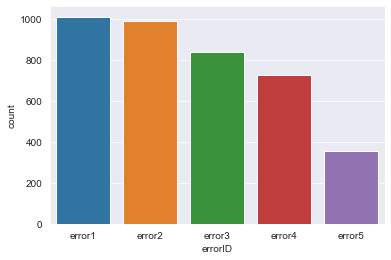

In [8]:
sns.set_style("darkgrid")
sns.countplot(errors['errorID'])

### 2.3 Maintenance

The are the scheduled and unscheduled maintenance records corresponds to both regular inspection of components as well as failures. A record is generated if a component is replaced during the scheduled inspection or replaced due to a breakdown. The records that are created due to breakdowns will be called failures which is explained in the later sections. Maintenance data has both 2014 and 2015 records.

In [9]:
# format datetime field which comes in as string
maint['datetime'] = pd.to_datetime(maint['datetime'], format="%Y-%m-%d %H:%M:%S")
maint['comp'] = maint['comp'].astype('category')

print('Total number of maintenance records: {}'.format(len(maint.index)))
maint.head()

Total number of maintenance records: 3286


,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [10]:
maint.machineID.unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

Text(0, 0.5, 'Count')

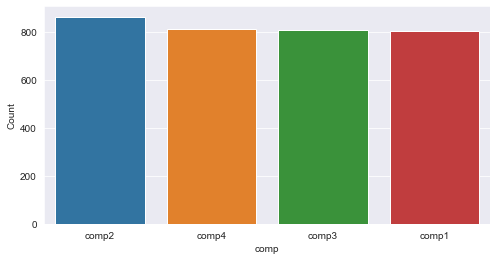

In [11]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
sns.countplot(maint['comp'])
plt.ylabel('Count')

### 2.4 Machines

This data set includes some information about the machines: model type and age (years in service).

In [12]:
machines['model'] = machines['model'].astype('category')

print('Total number of machines: {}'.format(len(machines.index)))
machines.head()

Total number of machines: 100


,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [12]:
machines.groupby('model')['age'].mean()

model
model1    12.250000
model2    12.764706
model3    12.028571
model4     9.343750
Name: age, dtype: float64

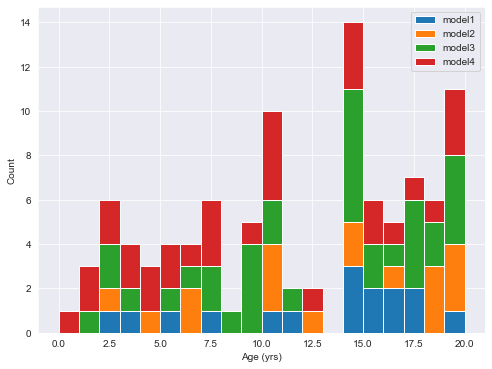

In [14]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 6))
_, bins, _ = plt.hist([machines.loc[machines['model'] == 'model1', 'age'],
                       machines.loc[machines['model'] == 'model2', 'age'],
                       machines.loc[machines['model'] == 'model3', 'age'],
                       machines.loc[machines['model'] == 'model4', 'age']],
                       20, stacked=True, label=['model1', 'model2', 'model3', 'model4'])
plt.xlabel('Age (yrs)')
plt.ylabel('Count')
plt.legend()

### 2.5 Failures

These are the records of component replacements due to failures. Each record has a date and time, machine ID, and failed component type.

In [3]:
# format datetime field which comes in as string
failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')

print('Total number of failures: {}'.format(len(failures.index)))
failures.head()

Total number of failures: 761


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


Text(0, 0.5, 'Count')

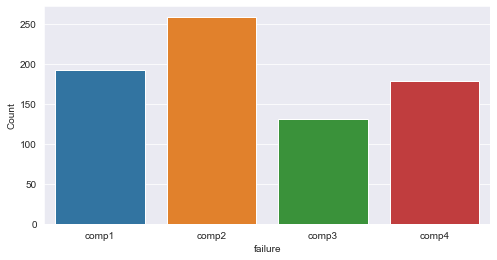

In [10]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
sns.countplot(failures['failure'])
plt.ylabel('Count')

## 3. Feature Engineering

Feature engineering requires bringing the different data sources together to create features that best describe a machines's health condition at a given point in time. In the next sections, several feature engineering methods are used to create features based on the properties of each data source.

### 3.1 Lag Features from Telemetry

Telemetry data comes with time-stamps and they can be used for calculating lagging features. We have to determine a window size for the lag features to be created and compute rolling aggregate measures such as mean and standard deviation in order to represent the short term history of the telemetry over the lag window. In the following, rolling mean and standard deviation of the telemetry data over the last 2 hour lag window is calculated for every 2 hours.

In [16]:
## Calculate mean values for telemetry features over 2 hrs
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).rolling(window=2).mean().resample('1H',
                                                                              closed='left',
                                                                              label='right').first().unstack())
telemetry_mean_2h = pd.concat(temp, axis=1)
telemetry_mean_2h.columns = [i + 'mean_2h' for i in fields]
telemetry_mean_2h.reset_index(inplace=True)
telemetry_mean_2h = telemetry_mean_2h.loc[-telemetry_mean_2h['voltmean_2h'].isnull()]
telemetry_mean_2h.head()

,machineID,datetime,voltmean_2h,rotatemean_2h,pressuremean_2h,vibrationmean_2h
1,1,2015-01-01 08:00:00,169.548538,410.625784,104.269230,44.250829
2,1,2015-01-01 09:00:00,166.934563,465.048658,85.349215,38.796410
3,1,2015-01-01 10:00:00,166.726368,436.749580,92.243233,37.650496
4,1,2015-01-01 11:00:00,160.036427,390.763104,110.567605,33.556328
5,1,2015-01-01 12:00:00,165.057430,432.850118,103.906845,30.822764


In [17]:
telemetry_mean_2h.shape

(876000, 6)

In [18]:
## Calculate standard deviation values for telemetry features
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).rolling(window=2).std().resample('1H',
                                                                              closed='left',
                                                                              label='right').first().unstack())
telemetry_std_2h = pd.concat(temp, axis=1)
telemetry_std_2h.columns = [i + 'std_2h' for i in fields]
telemetry_std_2h.reset_index(inplace=True)
telemetry_std_2h = telemetry_std_2h.loc[-telemetry_std_2h['voltstd_2h'].isnull()]
telemetry_std_2h.head()

,machineID,datetime,voltstd_2h,rotatestd_2h,pressurestd_2h,vibrationstd_2h
1,1,2015-01-01 08:00:00,9.431836,11.141591,12.457390,1.183494
2,1,2015-01-01 09:00:00,5.735116,88.107157,14.299552,6.530220
3,1,2015-01-01 10:00:00,6.029548,128.128096,24.049166,4.909652
4,1,2015-01-01 11:00:00,3.431456,63.093397,1.865409,10.699680
5,1,2015-01-01 12:00:00,10.532227,3.573372,11.285146,6.833838


In [19]:
telemetry_std_2h.shape

(876000, 6)

In [20]:
## Calculate mean values for telemetry features over 12 hrs
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).rolling(window=12).mean().resample('1H',
                                                                              closed='left',
                                                                              label='right').first().unstack())
telemetry_mean_12h = pd.concat(temp, axis=1)
telemetry_mean_12h.columns = [i + 'mean_12h' for i in fields]
telemetry_mean_12h.reset_index(inplace=True)
telemetry_mean_12h = telemetry_mean_12h.loc[-telemetry_mean_12h['voltmean_12h'].isnull()]
telemetry_mean_12h.head()

,machineID,datetime,voltmean_12h,rotatemean_12h,pressuremean_12h,vibrationmean_12h
11,1,2015-01-01 18:00:00,166.967614,429.934546,102.444134,39.190634
12,1,2015-01-01 19:00:00,165.062250,435.948616,100.188676,39.109040
13,1,2015-01-01 20:00:00,166.717241,437.236263,100.024046,38.938475
14,1,2015-01-01 21:00:00,166.662702,426.828877,101.523869,39.401894
15,1,2015-01-01 22:00:00,168.329725,439.809680,99.566707,40.226839


In [21]:
telemetry_mean_12h.shape

(875000, 6)

In [22]:
# repeat for standard deviation
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).rolling(window=12).std().resample('1H',
                                                                             closed='left',
                                                                             label='right').first().unstack())
telemetry_std_12h = pd.concat(temp, axis=1)
telemetry_std_12h.columns = [i + 'std_12h' for i in fields]
telemetry_std_12h.reset_index(inplace=True)
telemetry_std_12h = telemetry_std_12h.loc[-telemetry_std_12h['voltstd_12h'].isnull()]

# Notice that a 24h rolling average is not available at the earliest timepoints
telemetry_std_12h.head()

,machineID,datetime,voltstd_12h,rotatestd_12h,pressurestd_12h,vibrationstd_12h
11,1,2015-01-01 18:00:00,6.849631,49.650872,10.782098,5.619049
12,1,2015-01-01 19:00:00,7.213021,52.433305,11.178989,5.532069
13,1,2015-01-01 20:00:00,8.775702,51.728834,11.269133,5.417642
14,1,2015-01-01 21:00:00,8.748726,43.925228,8.536877,5.207254
15,1,2015-01-01 22:00:00,9.726885,40.822233,9.265976,6.195010


In [23]:
telemetry_std_12h.shape

(875000, 6)

In [24]:
# concatenate columns of feature sets created earlier
telemetry_feat = pd.concat([telemetry_mean_2h,
                            telemetry_std_2h.iloc[:, 2:6],
                            telemetry_mean_12h.iloc[:, 2:6],
                            telemetry_std_12h.iloc[:, 2:6]], axis=1).dropna()
telemetry_feat.describe()

,machineID,voltmean_2h,rotatemean_2h,pressuremean_2h,vibrationmean_2h,voltstd_2h,rotatestd_2h,pressurestd_2h,vibrationstd_2h,voltmean_12h,rotatemean_12h,pressuremean_12h,vibrationmean_12h,voltstd_12h,rotatestd_12h,pressurestd_12h,vibrationstd_12h
count,875000.000000,875000.000000,875000.000000,875000.000000,875000.000000,875000.000000,875000.000000,875000.000000,875000.000000,875000.000000,875000.000000,875000.000000,875000.000000,875000.000000,875000.000000,875000.000000,875000.000000
mean,50.500000,170.775095,446.610227,100.856230,40.384993,11.973139,40.023045,7.996154,3.998457,170.774972,446.609830,100.856586,40.384822,14.703891,49.174846,9.857964,4.917309
std,28.866087,11.307372,38.945234,8.470929,4.034503,9.052247,30.219081,6.048310,3.020821,5.742470,21.295964,5.334108,2.366742,3.190451,10.659754,2.209149,1.081064
min,1.000000,112.522895,182.247316,66.317729,22.874561,0.000047,0.000149,0.000010,0.000004,149.427287,254.131150,84.473685,33.669541,3.281143,12.161211,1.945681,1.153457
25%,25.750000,163.182453,422.681247,95.403200,37.728345,4.769652,15.985479,3.185032,1.597309,167.248394,438.460562,98.119599,39.080227,12.474139,41.764741,8.331484,4.164584
50%,50.500000,170.481499,448.044254,100.294597,40.179583,10.107236,33.840156,6.754811,3.381912,170.243001,449.051402,100.123072,40.089011,14.578661,48.728110,9.742310,4.869518
75%,75.250000,178.009866,472.666695,105.383173,42.712718,17.276455,57.697504,11.537972,5.761246,173.389893,459.137922,102.222225,41.142367,16.802157,56.086410,11.238826,5.614433
max,100.000000,244.267683,632.066513,169.691400,70.177421,81.969013,237.785755,50.919052,25.628583,226.230974,520.809846,156.601560,63.568548,33.221736,115.451569,27.054673,13.712220


In [25]:
telemetry_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 875000 entries, 11 to 876099
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   machineID          875000 non-null  int64         
 1   datetime           875000 non-null  datetime64[ns]
 2   voltmean_2h        875000 non-null  float64       
 3   rotatemean_2h      875000 non-null  float64       
 4   pressuremean_2h    875000 non-null  float64       
 5   vibrationmean_2h   875000 non-null  float64       
 6   voltstd_2h         875000 non-null  float64       
 7   rotatestd_2h       875000 non-null  float64       
 8   pressurestd_2h     875000 non-null  float64       
 9   vibrationstd_2h    875000 non-null  float64       
 10  voltmean_12h       875000 non-null  float64       
 11  rotatemean_12h     875000 non-null  float64       
 12  pressuremean_12h   875000 non-null  float64       
 13  vibrationmean_12h  875000 non-null  float64

### 3.2 Lag Features from Errors

Error IDs are categorical values and should not be averaged over time intervals like the telemetry measurements. Instead, we count the number of errors of each type in a lagging window. We begin by reformatting the error data to have one entry per machine per time at which at least one error occurred:

In [26]:
# create a column for each error type
error_count = pd.get_dummies(errors)
error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']

# combine errors for a given machine in a given hour
error_count = error_count.groupby(['machineID', 'datetime']).sum().reset_index()
error_count.head(13)

,machineID,datetime,error1,error2,error3,error4,error5
0,1,2015-01-03 07:00:00,1,0,0,0,0
1,1,2015-01-03 20:00:00,0,0,1,0,0
2,1,2015-01-04 06:00:00,0,0,0,0,1
3,1,2015-01-10 15:00:00,0,0,0,1,0
4,1,2015-01-22 10:00:00,0,0,0,1,0
5,1,2015-01-25 15:00:00,0,0,0,1,0
6,1,2015-01-27 04:00:00,1,0,0,0,0
7,1,2015-03-03 22:00:00,0,1,0,0,0
8,1,2015-03-05 06:00:00,1,0,0,0,0
9,1,2015-03-20 18:00:00,1,0,0,0,0


Now we add blank entries for all other hourly timepoints (since no errors occurred at those times):

In [27]:
error_count = telemetry[['datetime', 'machineID']].merge(error_count, on=['machineID', 'datetime'], how='left').fillna(0.0)
error_count.head(10)

,datetime,machineID,error1,error2,error3,error4,error5
0,2015-01-01 06:00:00,1,0.0,0.0,0.0,0.0,0.0
1,2015-01-01 07:00:00,1,0.0,0.0,0.0,0.0,0.0
2,2015-01-01 08:00:00,1,0.0,0.0,0.0,0.0,0.0
3,2015-01-01 09:00:00,1,0.0,0.0,0.0,0.0,0.0
4,2015-01-01 10:00:00,1,0.0,0.0,0.0,0.0,0.0
5,2015-01-01 11:00:00,1,0.0,0.0,0.0,0.0,0.0
6,2015-01-01 12:00:00,1,0.0,0.0,0.0,0.0,0.0
7,2015-01-01 13:00:00,1,0.0,0.0,0.0,0.0,0.0
8,2015-01-01 14:00:00,1,0.0,0.0,0.0,0.0,0.0
9,2015-01-01 15:00:00,1,0.0,0.0,0.0,0.0,0.0


In [28]:
error_count.describe()

,machineID,error1,error2,error3,error4,error5
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,0.001153,0.001128,0.000957,0.000830,0.000406
std,28.866087,0.033934,0.033563,0.030913,0.028795,0.020154
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.250000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Finally, we can compute the total number of errors of each type over the last 24 hours, for timepoints taken every three hours:

In [29]:
temp = []
fields = ['error%d' % i for i in range(1,6)]
for col in fields:
    temp.append(pd.pivot_table(error_count,
                               index='datetime',
                               columns='machineID',
                               values=col).rolling(window=12).sum().resample('1H',
                                                                             closed='left',
                                                                             label='right').first().unstack())
error_count = pd.concat(temp, axis=1)
error_count.columns = [i + 'count' for i in fields]
error_count.reset_index(inplace=True)
error_count = error_count.dropna()
error_count.head(10)

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
11,1,2015-01-01 18:00:00,0.0,0.0,0.0,0.0,0.0
12,1,2015-01-01 19:00:00,0.0,0.0,0.0,0.0,0.0
13,1,2015-01-01 20:00:00,0.0,0.0,0.0,0.0,0.0
14,1,2015-01-01 21:00:00,0.0,0.0,0.0,0.0,0.0
15,1,2015-01-01 22:00:00,0.0,0.0,0.0,0.0,0.0
16,1,2015-01-01 23:00:00,0.0,0.0,0.0,0.0,0.0
17,1,2015-01-02 00:00:00,0.0,0.0,0.0,0.0,0.0
18,1,2015-01-02 01:00:00,0.0,0.0,0.0,0.0,0.0
19,1,2015-01-02 02:00:00,0.0,0.0,0.0,0.0,0.0
20,1,2015-01-02 03:00:00,0.0,0.0,0.0,0.0,0.0


In [30]:
error_count.describe()

,machineID,error1count,error2count,error3count,error4count,error5count
count,875000.000000,875000.000000,875000.000000,875000.000000,875000.000000,875000.000000
mean,50.500000,0.013821,0.013525,0.011458,0.009947,0.004872
std,28.866087,0.117555,0.116098,0.107081,0.099630,0.069793
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.250000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,2.000000,2.000000,2.000000,2.000000,2.000000


### 3.3 Days Since Last Replacement from Maintenance

A crucial data set in this example is the maintenance records which contain the information of component replacement records. Possible features from this data set can be, for example, the number of replacements of each component in the last 3 months to incorporate the frequency of replacements. However, more relevent information would be to calculate how long it has been since a component is last replaced as that would be expected to correlate better with component failures since the longer a component is used, the more degradation should be expected. 

Creating lagging features from maintenance data is not as straightforward as for telemetry and errors, so the features from this data are generated in a more custom way. The days since last component replacement are calculated for each component type as features from the maintenance data. 

In [31]:
# create a column for each error type
comp_rep = pd.get_dummies(maint)
comp_rep.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']
comp_rep.head(10)

,datetime,machineID,comp1,comp2,comp3,comp4
0,2014-06-01 06:00:00,1,0,1,0,0
1,2014-07-16 06:00:00,1,0,0,0,1
2,2014-07-31 06:00:00,1,0,0,1,0
3,2014-12-13 06:00:00,1,1,0,0,0
4,2015-01-05 06:00:00,1,0,0,0,1
5,2015-01-05 06:00:00,1,1,0,0,0
6,2015-01-20 06:00:00,1,0,0,1,0
7,2015-01-20 06:00:00,1,1,0,0,0
8,2015-02-04 06:00:00,1,0,0,0,1
9,2015-02-04 06:00:00,1,0,0,1,0


In [32]:
# combine repairs for a given machine in a given hour
comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()
comp_rep.head(10)


,machineID,datetime,comp1,comp2,comp3,comp4
0,1,2014-06-01 06:00:00,0,1,0,0
1,1,2014-07-16 06:00:00,0,0,0,1
2,1,2014-07-31 06:00:00,0,0,1,0
3,1,2014-12-13 06:00:00,1,0,0,0
4,1,2015-01-05 06:00:00,1,0,0,1
5,1,2015-01-20 06:00:00,1,0,1,0
6,1,2015-02-04 06:00:00,0,0,1,1
7,1,2015-02-19 06:00:00,0,0,1,0
8,1,2015-03-06 06:00:00,1,0,0,0
9,1,2015-03-21 06:00:00,1,0,0,0


In [33]:
# add timepoints where no components were replaced
comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                      on=['datetime', 'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])

components = ['comp1', 'comp2', 'comp3', 'comp4']
for comp in components:
    # convert indicator to most recent date of component change
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']
    
    # forward-fill the most-recent date of component change
    comp_rep[comp] = comp_rep[comp].fillna(method='ffill')
    
# remove dates in 2014 (may have NaN or future component change dates)    
comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]
comp_rep.head(10)

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,1.418450e+18,1401602400000000000,1.406786e+18,1.405490e+18
1,2015-01-01 07:00:00,1,1.418450e+18,1401602400000000000,1.406786e+18,1.405490e+18
2,2015-01-01 08:00:00,1,1.418450e+18,1401602400000000000,1.406786e+18,1.405490e+18
3,2015-01-01 09:00:00,1,1.418450e+18,1401602400000000000,1.406786e+18,1.405490e+18
4,2015-01-01 10:00:00,1,1.418450e+18,1401602400000000000,1.406786e+18,1.405490e+18
5,2015-01-01 11:00:00,1,1.418450e+18,1401602400000000000,1.406786e+18,1.405490e+18
6,2015-01-01 12:00:00,1,1.418450e+18,1401602400000000000,1.406786e+18,1.405490e+18
7,2015-01-01 13:00:00,1,1.418450e+18,1401602400000000000,1.406786e+18,1.405490e+18
8,2015-01-01 14:00:00,1,1.418450e+18,1401602400000000000,1.406786e+18,1.405490e+18
9,2015-01-01 15:00:00,1,1.418450e+18,1401602400000000000,1.406786e+18,1.405490e+18


In [34]:
comp_rep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 876100 entries, 0 to 876099
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   datetime   876100 non-null  datetime64[ns]
 1   machineID  876100 non-null  int64         
 2   comp1      876100 non-null  float64       
 3   comp2      876100 non-null  int64         
 4   comp3      876100 non-null  float64       
 5   comp4      876100 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 46.8 MB


In [35]:
for comp in components:
    comp_rep[comp] = (comp_rep['datetime'] - pd.to_datetime(comp_rep[comp])).apply(lambda x: x / pd.Timedelta(days=1))

In [36]:
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,19.000000,214.000000,154.000000,169.000000
1,2015-01-01 07:00:00,1,19.041667,214.041667,154.041667,169.041667
2,2015-01-01 08:00:00,1,19.083333,214.083333,154.083333,169.083333
3,2015-01-01 09:00:00,1,19.125000,214.125000,154.125000,169.125000
4,2015-01-01 10:00:00,1,19.166667,214.166667,154.166667,169.166667


### 3.4 Machine Features

Lastly, we merge all the feature data sets we created earlier to get the final feature matrix.

In [37]:
final_feat = telemetry_feat.merge(error_count, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(comp_rep, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(machines, on=['machineID'], how='left')
comps=['comp1','comp2','comp3','comp4']
for i in comps:
    final_feat[i] = final_feat[i].fillna(method='ffill')
print(final_feat.head())


   machineID            datetime  voltmean_2h  rotatemean_2h  pressuremean_2h  \
0          1 2015-01-01 18:00:00   163.662467     415.283899       100.130819   
1          1 2015-01-01 19:00:00   156.808723     469.378588        91.246708   
2          1 2015-01-01 20:00:00   168.046302     454.436086        89.748697   
3          1 2015-01-01 21:00:00   176.537275     410.330219        93.360371   
4          1 2015-01-01 22:00:00   176.401274     452.190080        89.499201   

   vibrationmean_2h  voltstd_2h  rotatestd_2h  pressurestd_2h  \
0         40.609740    4.806224     46.386709        5.161658   
1         41.326118    4.886435     30.114734        7.402372   
2         42.737872   20.778772     51.246623        5.283865   
3         40.553536    8.770723     11.128493        0.176188   
4         45.380684    8.578387     70.327275        5.284331   

   vibrationstd_2h  ...  error2count  error3count  error4count  error5count  \
0         2.921849  ...          0.0       

In [38]:
final_feat.shape

(875000, 29)

In [39]:
final_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 875000 entries, 0 to 874999
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   machineID          875000 non-null  int64         
 1   datetime           875000 non-null  datetime64[ns]
 2   voltmean_2h        875000 non-null  float64       
 3   rotatemean_2h      875000 non-null  float64       
 4   pressuremean_2h    875000 non-null  float64       
 5   vibrationmean_2h   875000 non-null  float64       
 6   voltstd_2h         875000 non-null  float64       
 7   rotatestd_2h       875000 non-null  float64       
 8   pressurestd_2h     875000 non-null  float64       
 9   vibrationstd_2h    875000 non-null  float64       
 10  voltmean_12h       875000 non-null  float64       
 11  rotatemean_12h     875000 non-null  float64       
 12  pressuremean_12h   875000 non-null  float64       
 13  vibrationmean_12h  875000 non-null  float64 

In the notebook on predictive modelling, the final_feat dataframe will be used for training predictive models.

In [40]:
final_feat.to_pickle("final_feat.pkl")